# Introduction
In the dynamic realm of financial markets, the ability to predict stock prices remains a coveted yet challenging endeavor. Traders, investors, and researchers alike have sought to harness the power of advanced technologies and machine learning algorithms to gain insights into the intricate patterns of stock movements. Among the myriad of approaches, the combination of Long Short-Term Memory (LSTM), Extreme Gradient Boosting (XGBoost), and Random Forest has emerged as a compelling strategy for stock prediction. <br>
This project is divided into three parts each focussed on different algorithms. For this analysis, Boeing stock is chosen as the focal point of the stock prediction project. As since the past two decades, the Boeing company has been through a lot of developments and changes due to its reputation as the Aerospace giant. From introduction to the 737-Max aircrafts with highest ever peaks in stock market to the crashes, the Boeing company has been into a steady turmoil recently.<br>
By applying the intricate capabilities of LSTM, XGBoost, and Random Forest, the aim is to unravel the historical patterns and trends specific to Boeing's stock performance. This comprehensive exploration will delve into the dynamics of Boeing's stock movements, leveraging the strengths of each algorithm to provide nuanced insights. Through this focused approach, the endeavor is to enhance the understanding of the factors influencing Boeing's stock prices and contribute to the broader discourse on effective stock prediction methodologies in the financial domain.

In [19]:
#pip install nbconvert

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import yfinance as yf


import warnings
warnings.filterwarnings("ignore")

### Data Import and Load
The data is originally obtained from https://github.com/yumoxu/stocknet-dataset <br>
It can be obtained from _yfinance_ directly with any specified time frame. Then the data is processed to create extra features like **Moving Average**, **Close Lagged Values** and **Volatility**. These extra features are very necessary as they capture important aspects of a stock's historical price behavior, providing valuable information for understanding trends, patterns, and potential future movements. 



In [23]:
os.chdir(r"C:\\Users\\mraer\\Desktop\\UW\\Semester 3\\ML-2\\Project")

data = pd.read_csv("Regression - Price Data\\raw\\BA.csv")

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB
None
         Date       Open       High        Low      Close  Adj Close   Volume
0  2012-09-04  71.500000  71.500000  70.400002  70.870003  62.269939  3916400
1  2012-09-05  71.379997  72.050003  71.110001  71.919998  63.192505  4946900
2  2012-09-06  72.370003  73.269997  72.370003  72.820000  63.983288  4358800
3  2012-09-07  72.870003  73.029999  72.550003  72.889999  64.044792  3080400
4  2012-09-10  72.309998  72.320000  70.809998  71.080002  62.454441  835450

In [24]:
data['MA_7days'] = data['Close'].rolling(window=7).mean()
#data['MA_30days'] = data['Close'].rolling(window=30).mean()

#data['Price_change'] = data['Close'] - data['Close'].shift(1)
Price_change = data['Close'] - data['Close'].shift(1)

#data['Volatility'] = data['Price_change'].rolling(window=30).std()
data['Volatility'] = Price_change.rolling(window=30).std()

data['Close_lagged_7'] = data['Close'].shift(7)
#data['Close_lagged_30'] = data['Close'].shift(30)


data= data.dropna()
df= data.drop('Volume', axis =1)

cols = list(df)[1:]

df.head()

print('Training set shape == {}'.format(df.shape))
print('All timestamps == {}'.format(len(df)))
print('Featured selected: {}'.format(cols))

Training set shape == (1228, 9)
All timestamps == 1228
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'MA_7days', 'Volatility', 'Close_lagged_7']


In [25]:
print(df.isnull().sum())
print(df.isna().sum())

Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
MA_7days          0
Volatility        0
Close_lagged_7    0
dtype: int64
Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
MA_7days          0
Volatility        0
Close_lagged_7    0
dtype: int64


### Date Extraction


In [26]:
import datetime as dt

nf = 5
npast = 20

datelist_train = list(df['Date'][:df.shape[0]-(2*npast + nf -1)])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
print('All timestamps == {}'.format(len(datelist_train)))

datelist_test = list(df['Date'][df.shape[0]-(2*npast + nf -1):])
datelist_test = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_test]
print('All timestamps == {}'.format(len(datelist_test)))



df["Date"] = pd.to_datetime(df["Date"])
print(df.head())
print(df.info())

date = df['Date']
print(date)



All timestamps == 1184
All timestamps == 44
         Date       Open       High        Low      Close  Adj Close  \
30 2012-10-16  72.760002  73.709999  72.500000  73.480003  64.563210   
31 2012-10-17  73.739998  73.900002  72.629997  73.629997  64.694992   
32 2012-10-18  73.519997  74.260002  73.239998  74.260002  65.248543   
33 2012-10-19  74.029999  74.230003  73.589996  74.010002  65.028893   
34 2012-10-22  73.800003  74.150002  73.250000  73.699997  64.756500   

     MA_7days  Volatility  Close_lagged_7  
30  71.422857    0.695935       70.889999  
31  71.859999    0.671977       70.570000  
32  72.377143    0.662032       70.639999  
33  72.901429    0.664239       70.339996  
34  73.311428    0.570185       70.830002  
<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 30 to 1257
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1228 non-null   datetime64[ns]
 

### Plots

The following plots are original prices, smoothened data by moving average with 30 days and the distribution of the data.

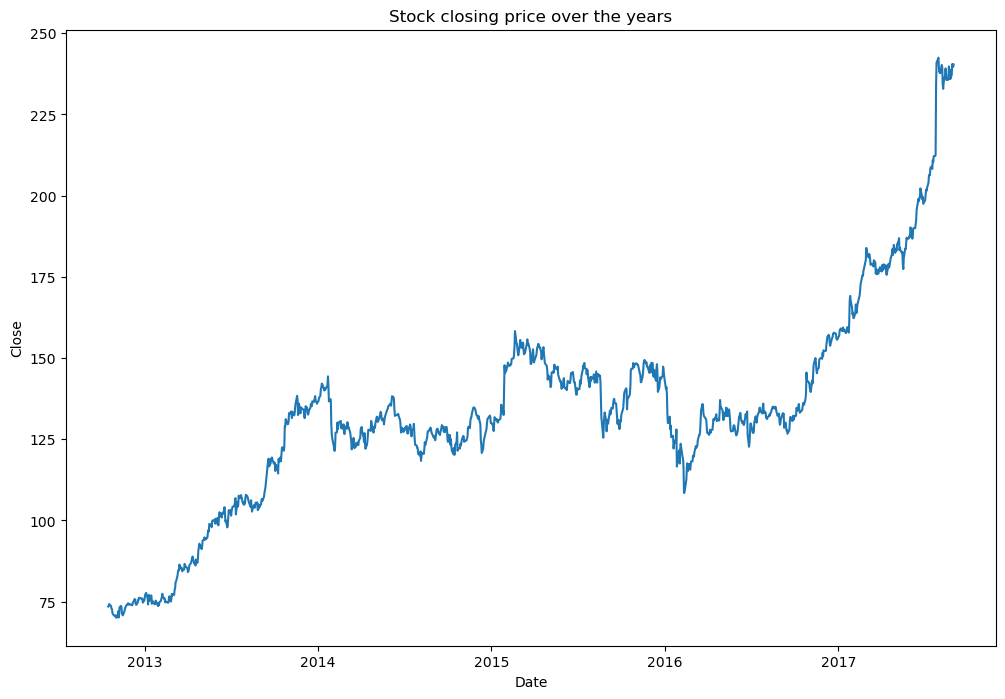

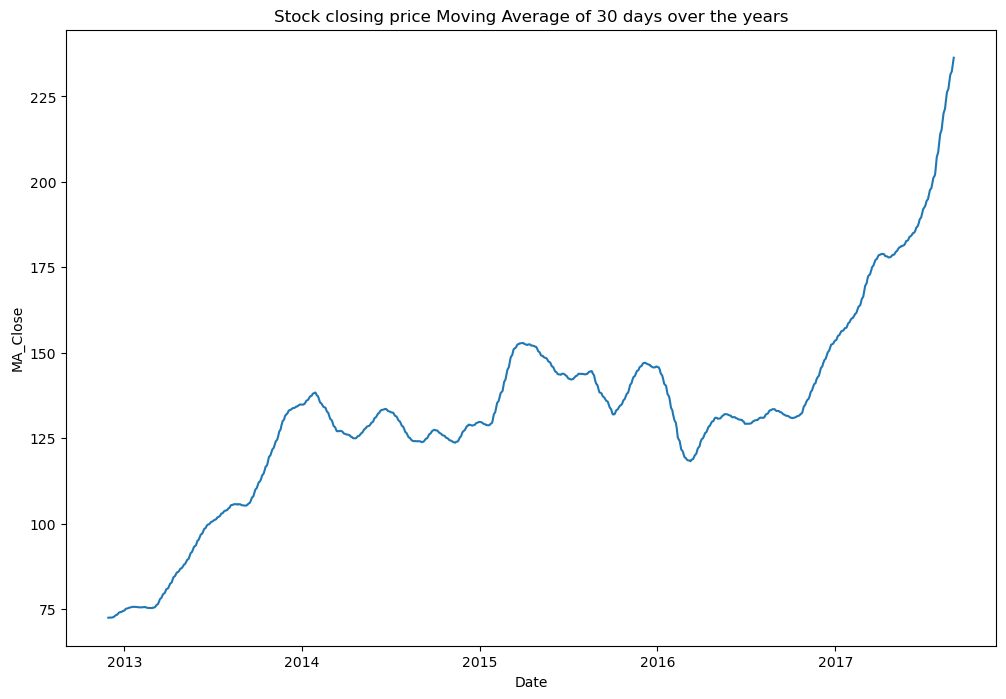

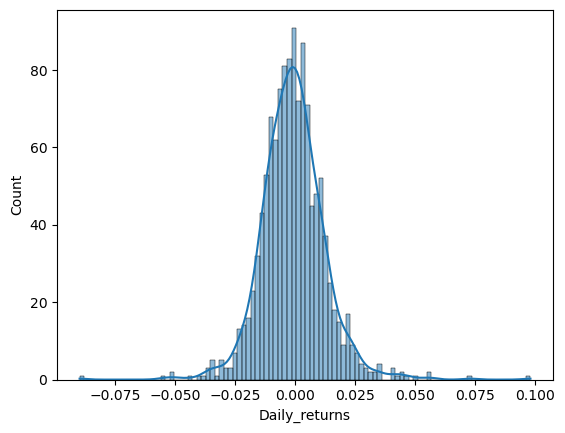

In [27]:
def plot(df):

    dat_copy = df.copy() #To avoid modification of the original file
    #Line Plot
    plt.figure(figsize=(12,8))
    sns.lineplot(x='Date', y = 'Close', data = dat_copy)
    plt.title("Stock closing price over the years")
    plt.savefig("OverAll stock.jpg", dpi=500)
    plt.show()
    
    #Moving Average
    plt.figure(figsize=(12,8))
    dat_copy['MA_Close'] = dat_copy['Close'].rolling(window=30).mean()
    sns.lineplot(x='Date', y = 'MA_Close', data = dat_copy)
    plt.title("Stock closing price Moving Average of 30 days over the years")
    plt.savefig("30days moving average.jpg", dpi=500)
    plt.show()
    
    #Daily Returns in terms of investment
    dat_copy['Daily_Lags'] = dat_copy['Close'].shift(1)
    dat_copy['Daily_returns'] = (dat_copy['Daily_Lags']/dat_copy['Close'])-1
    sns.histplot(dat_copy['Daily_returns'],bins=100, kde=True) #Using histogram
    plt.savefig("histogram", dpi=500)
    


plot(df)

In [28]:
clean = df[cols].astype(float)

In [29]:
print(cols)
print(clean.head)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'MA_7days', 'Volatility', 'Close_lagged_7']
<bound method NDFrame.head of             Open        High         Low       Close   Adj Close    MA_7days  \
30     72.760002   73.709999   72.500000   73.480003   64.563210   71.422857   
31     73.739998   73.900002   72.629997   73.629997   64.694992   71.859999   
32     73.519997   74.260002   73.239998   74.260002   65.248543   72.377143   
33     74.029999   74.230003   73.589996   74.010002   65.028893   72.901429   
34     73.800003   74.150002   73.250000   73.699997   64.756500   73.311428   
...          ...         ...         ...         ...         ...         ...   
1253  236.220001  237.550003  234.610001  237.179993  237.179993  237.299999   
1254  237.210007  241.169998  236.080002  240.490005  240.490005  237.974284   
1255  240.990005  241.440002  239.000000  240.460007  240.460007  238.657144   
1256  241.000000  241.100006  238.410004  239.660004  239.660004  238.644287   


### Data Scaling and Splitting
The next process in data preparation is the scaling of the data as it is essential, particularly when utilizing models like LSTM.<br>
Features such as 'Open,' 'High,' 'Low,' 'Close,' 'Adj Close,' 'MA_7days,' 'Volatility,' and 'Close_lagged_7' often have varying magnitudes. Scaling ensures uniformity, aiding optimization algorithms and preventing any single feature from dominating the model. For LSTM, efficient convergence and improved learning are achieved through standardizing or normalizing input features. Consistent scaling practices across training and testing datasets contribute to the model's ability to generalize effectively and enhance the accuracy of stock price predictions.<br>
For simplicity, the scale is maintained from 0 to 1.<br> <br>
After Data scaling, it is splittted into train and test data. A very important thing to note here is that the splitted data is a function of _npast_ and _nf_ which are the number of days that are used as training set to predict next few day's price. More details will be discussed in [data preparation section here.](#LSTM)

In [30]:
scaled = MinMaxScaler(feature_range=(0,1))

# clean

data_scaled = scaled.fit_transform(clean)

print(data_scaled.shape)

# nf = 5
# npast = 20

data_scaled_train = data_scaled[:data_scaled.shape[0]-(2*npast + nf -1)]
data_scaled_test = data_scaled[data_scaled.shape[0]-(2*npast + nf -1):]

print("Shape of data_scaled_train:", data_scaled_train.shape)
print("Shape of data_scaled_test:", data_scaled_test.shape)


print("Shape of data_scaled_test:", data_scaled_test)

(1228, 8)
Shape of data_scaled_train: (1184, 8)
Shape of data_scaled_test: (44, 8)
Shape of data_scaled_test: [[0.73886233 0.73250326 0.74455132 0.74554834 0.75701135 0.76036101
  0.24696396 0.75047849]
 [0.74595123 0.74785375 0.75098536 0.76422477 0.77484641 0.76000606
  0.25134402 0.76666081]
 [0.75943746 0.74984366 0.7621145  0.76231071 0.77301856 0.76127373
  0.25207608 0.75361052]
 [0.76289551 0.75433507 0.76489676 0.76747282 0.77794819 0.7642147
  0.24839772 0.7472884 ]
 [0.76335659 0.76172607 0.77028748 0.77669509 0.78675498 0.76788248
  0.24689169 0.75152247]
 [0.77303899 0.77355165 0.780779   0.79009337 0.79954964 0.77532789
  0.25177395 0.73899426]
 [0.79004088 0.78463811 0.79422676 0.79107938 0.80049123 0.78267188
  0.2520635  0.74067626]
 [0.78917641 0.77548466 0.78860422 0.78986132 0.79932807 0.78912851
  0.25405704 0.74554834]
 [0.78917641 0.78532033 0.79666125 0.8030856  0.8119566  0.79479073
  0.25874643 0.76422477]
 [0.80029964 0.79094887 0.80721071 0.80592769 0.814670

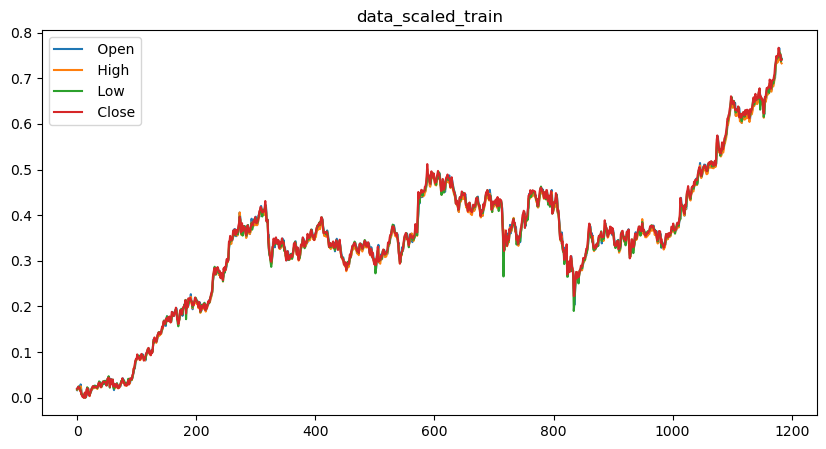

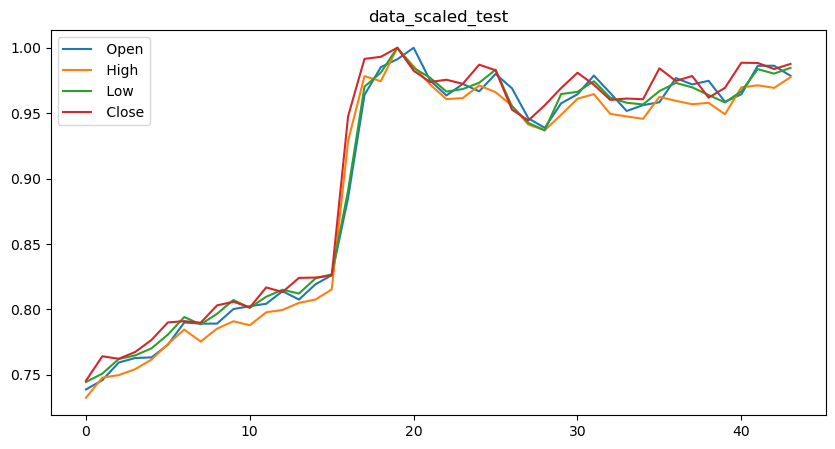

(1228, 8)
(1184, 8)
(44, 8)


In [31]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(data_scaled_train[:, i], label=f' {cols[i]}')

plt.title('data_scaled_train')
plt.legend()
plt.show()

# Plot data_scaled_test
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(data_scaled_test[:, i], label=f' {cols[i]}')

plt.title('data_scaled_test')
plt.legend()
plt.show()

print(data_scaled.shape)
print(data_scaled_train.shape)
print(data_scaled_test.shape)

## LSTM

### Data Preparation and Splitting

In [32]:
X_train_LSTM = []
Y_train_LSTM = []

X_test_LSTM = []
Y_test_LSTM = []

# nf = 5 #number of days we want to predict using previous days
# npast = 20 #number of days we want to use to predict nf

# Here it makes sense to go for a weekly train and next day predict approach

#Now formatting the data into input shapes: number of samples x timesteps x features
#shape of Boeing data is (1258, 5)

for i in range(npast, len(data_scaled_train) - nf +1):
    X_train_LSTM.append(data_scaled_train[i - npast : i, 0: clean.shape[1]])
    Y_train_LSTM.append(data_scaled_train[i + nf-1 : i + nf, 0])


for i in range(npast, len(data_scaled_test) - nf +1):
    X_test_LSTM.append(data_scaled_test[i - npast : i, 0: clean.shape[1]])
    Y_test_LSTM.append(data_scaled_test[i + nf-1 : i + nf, 0])


X_train_LSTM, Y_train_LSTM = np.array(X_train_LSTM), np.array(Y_train_LSTM)

X_test_LSTM, Y_test_LSTM = np.array(X_test_LSTM), np.array(Y_test_LSTM)

print('X train shape is {}.'.format(X_train_LSTM.shape))
print('Y train shape is {}.'.format(Y_train_LSTM.shape))

print('X test shape is {}.'.format(X_test_LSTM.shape))
print('Y test shape is {}.'.format(Y_test_LSTM.shape))

X train shape is (1160, 20, 8).
Y train shape is (1160, 1).
X test shape is (20, 20, 8).
Y test shape is (20, 1).


### Modules import

In [33]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras import regularizers
import random

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
# np.random.seed(42)
# tf.random.set_seed(42)

### LSTM Model Development

In [34]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Initializing the Neural Network based on LSTM
model = Sequential()


# AMAZING
model.add(LSTM(units=100,activation='relu', return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]),kernel_regularizer=regularizers.l2(0.005)))

model.add(Dropout(0.03))

#Adding 1st LSTM layer
model.add(LSTM(units=32,activation='tanh', return_sequences=False, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]),kernel_regularizer=regularizers.l2(0.005)))

model.add(Dropout(0.03))

# # Adding 2nd LSTM layer
# model.add(LSTM(units=100, activation='tanh', return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

# # Adding Dropout
# model.add(Dropout(0.03))

# model.add(LSTM(units=10, activation='tanh', return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

# # Adding Dropout
# model.add(Dropout(0.05))

# model.add(LSTM(units=10, activation='tanh', return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

# # Adding Dropout
# model.add(Dropout(0.25))


# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae'])

### Model Training

In [35]:
%%time
# np.random.seed(42)
# tf.random.set_seed(42)
es = EarlyStopping(monitor='val_loss', min_delta=3e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_LSTM, Y_train_LSTM, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose = 1, batch_size = 32)


Epoch 1/100


29/29 [==============================] - ETA: 0s - loss: 0.5126 - mae: 0.0813
Epoch 1: val_loss improved from inf to 0.37719, saving model to weights.h5
29/29 [==============================] - 4s 43ms/step - loss: 0.5126 - mae: 0.0813 - val_loss: 0.3772 - val_mae: 0.0575 - lr: 0.0010
Epoch 2/100
26/29 [=========================>....] - ETA: 0s - loss: 0.2958 - mae: 0.0269
Epoch 2: val_loss improved from 0.37719 to 0.21252, saving model to weights.h5
29/29 [==============================] - 1s 20ms/step - loss: 0.2879 - mae: 0.0268 - val_loss: 0.2125 - val_mae: 0.0444 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 0.1613 - mae: 0.0246
Epoch 3: val_loss improved from 0.21252 to 0.12027, saving model to weights.h5
29/29 [==============================] - 1s 22ms/step - loss: 0.1613 - mae: 0.0246 - val_loss: 0.1203 - val_mae: 0.0517 - lr: 0.0010
Epoch 4/100
27/29 [==========================>...] - ETA: 0s - loss: 0.0917 - mae: 0.0254
Epoch 

### Training vs Validation Loss plot

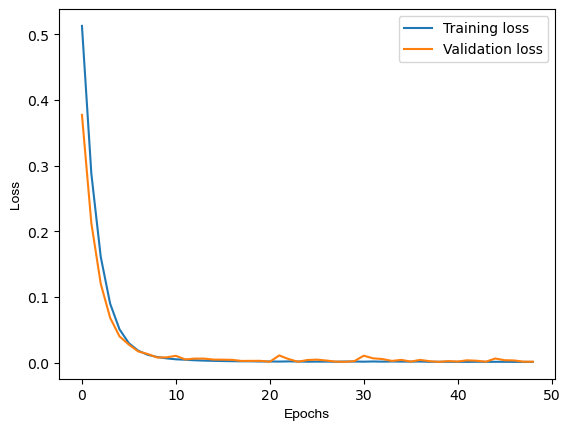

In [36]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs', family='Arial', fontsize=10)
plt.ylabel('Loss', family='Arial', fontsize=10)
plt.legend()
plt.savefig('rtd_10032_0303.jpg', dpi=500)
# model.history.history['val_mae'], label='Validation MAE'

In [37]:
# datelist_future = pd.date_range(datelist_train[-1], periods=nf, freq='1d').tolist()

# # Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
# datelist_future_ = []
# for this_timestamp in datelist_future:
#     datelist_future_.append(this_timestamp.date())

datelist_future = datelist_test

In [38]:
predictions_future = model.predict(X_train_LSTM[-nf:])

predictions_train = model.predict(X_train_LSTM[npast:])


36/36 [==============================] - 0s 6ms/step


In [39]:
predictions_future.shape

(5, 1)

In [40]:
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


#y_pred_future = scaled.inverse_transform(predictions_future)

prediction_future_copies = np.repeat(predictions_future, clean.shape[1], axis=-1)
y_pred_future = scaled.inverse_transform(prediction_future_copies)[:,0]

prediction_past_copies = np.repeat(predictions_train, clean.shape[1], axis=-1)
y_pred_past = scaled.inverse_transform(prediction_past_copies)[:,0]

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future[:nf])) # Changed datelist_future_ from datelist_future
PREDICTION_TRAIN = pd.DataFrame(y_pred_past, columns=['Open']).set_index(pd.Series(datelist_train[(2 * npast + nf -1): len(data_scaled_train)]))

#PREDICTION_TRAIN = pd.DataFrame(y_pred_past, columns=['Open']).set_index(pd.Series(datelist_train[:761]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

print(PREDICTION_TRAIN.tail(30))
print(PREDICTIONS_FUTURE.head(30))
print(PREDICTION_TRAIN.shape)
print(PREDICTION_TRAIN.index)
print(PREDICTIONS_FUTURE.index)

                  Open
2017-05-19  186.944321
2017-05-22  187.535477
2017-05-23  188.014252
2017-05-24  188.499222
2017-05-25  188.875595
2017-05-26  189.085266
2017-05-30  189.138901
2017-05-31  189.087311
2017-06-01  189.168655
2017-06-02  189.246689
2017-06-05  189.442642
2017-06-06  189.761780
2017-06-07  190.060410
2017-06-08  190.419403
2017-06-09  190.808838
2017-06-12  191.198425
2017-06-13  191.561722
2017-06-14  191.909927
2017-06-15  192.515564
2017-06-16  193.101990
2017-06-19  193.743027
2017-06-20  194.546509
2017-06-21  195.458649
2017-06-22  196.550323
2017-06-23  197.941574
2017-06-26  199.314224
2017-06-27  200.491119
2017-06-28  201.831055
2017-06-29  203.224533
2017-06-30  204.559937
                  Open
2017-07-03  199.314224
2017-07-05  200.491119
2017-07-06  201.831055
2017-07-07  203.224533
2017-07-10  204.559921
(1140, 1)
DatetimeIndex(['2012-12-20', '2012-12-21', '2012-12-24', '2012-12-26',
               '2012-12-27', '2012-12-28', '2012-12-31', '2013-01-02

In [41]:
df1 = pd.DataFrame(df, columns=cols)
#df[:df.shape[0]-(2*npast + nf -1)].index = datelist_train
# df1.info
df1 = df[:df.shape[0]-(2*npast + nf -1)]
df1.info
# df1.index = pd.to_datetime(datelist_train[:df.shape[0]-(2*npast + nf -1)])

df1.index = datelist_train
df1.index = pd.to_datetime(df1.index)

# print(df.index)

In [42]:
Y_test = data[data_scaled.shape[0]-(2*npast + nf -1):data_scaled.shape[0]-(2*npast -1)]

Y_test = Y_test[['Date','Open']]

Y_test["Date"] = pd.to_datetime(Y_test["Date"])
print(Y_test)

           Date        Open
1214 2017-07-03  198.070007
1215 2017-07-05  199.300003
1216 2017-07-06  201.639999
1217 2017-07-07  202.240005
1218 2017-07-10  202.320007


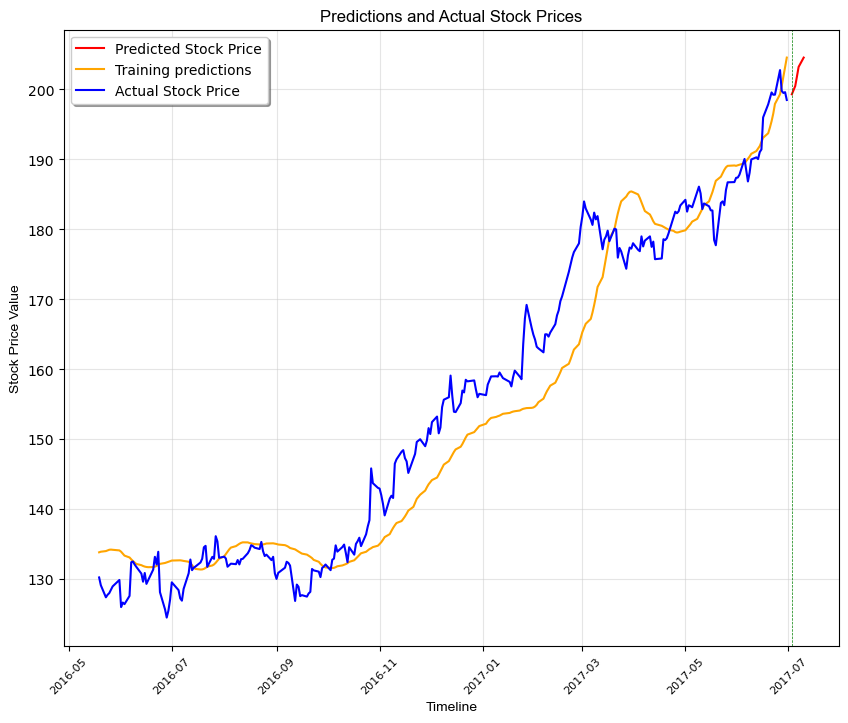

In [43]:
START_DATE_FOR_PLOTTING = pd.to_datetime('2016-05-19')


STOP_DATE_FOR_PLOTTING = '2012-09-04'

plt.figure(figsize=(10,8))

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df1.loc[START_DATE_FOR_PLOTTING:].index, df1.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x=min(PREDICTIONS_FUTURE.index), color='green', linewidth=0.5, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.savefig('rtd_10032_0303_pred.jpg', dpi=500,  bbox_inches='tight')
plt.show()


In [44]:

def evaluate(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

mae, mse, rmse = evaluate(Y_test['Open'], PREDICTIONS_FUTURE)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 1.797969704266152
Mean Squared Error: 1.1701663322265632
Root Mean Squared Error: 1.3408839264702042


## XGBoost

In [45]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb

Scaling is not explicitly required but as the scaled data is already prepared and it is very stable, having values closer to unit scales instead of billions (or nanos) is more convenient; numerically the whole system is more stable.

So we are using the already scaled data

In [46]:
search = {
    'learning_rate': [0,0.1,0.15],
    'gamma':[0,0.001,0.01,0.05,0.07,1],
    'reg_lambda': [0,0.1,0.2],
    'max_depth': [10,30,50],
    'subsample': [0.2,0.5,0.7,0.9,0.95]
}

X_train_LSTM was having 1160 rows, 20 was the number of days used to predict, 8 was the number of columns. For XGBoost, we needed a 2d array.   Thus we simply took all the rows and multiplied the features with number of days. By logic, each feature is having 20 days of values. So for 8 columns, it is 160 net.

In [47]:
XGB_X_train = X_train_LSTM.reshape(X_train_LSTM.shape[0],-1)
XGB_X_test = X_test_LSTM.reshape(X_test_LSTM.shape[0],-1)

XGB_Y_train = Y_train_LSTM
XGB_Y_test = Y_test_LSTM

print(XGB_X_train.shape)
print(XGB_X_test.shape)
print(XGB_Y_train.shape)
print(XGB_Y_test.shape)

(1160, 160)
(20, 160)
(1160, 1)
(20, 1)


In [221]:
grid = GridSearchCV(XGBRegressor(), search, cv=3)

grid.fit(XGB_X_train, XGB_Y_train)

#print(grid.best_params_)

best_para_XGB = grid.best_params_

In [49]:
best_para = {'gamma': 0.001,
 'learning_rate': 0.1,
 'max_depth': 10,
 'reg_lambda': 0.1,
 'subsample': 0.2}

## Cross validation attempt

"The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem."
<br> **Source** https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [50]:
cvmodelXGB = XGBRegressor(**best_para)
n_splits = 5
np.random.seed(1)
cvXGB = TimeSeriesSplit(n_splits= n_splits)
cvscoreXGB = cross_val_score(cvmodelXGB, XGB_X_train, XGB_Y_train, cv = cvXGB, scoring='neg_mean_squared_error')

print(cvscoreXGB)

[-0.02027647 -0.00278031 -0.00088808 -0.00080077 -0.02107745]


In [51]:
XGB = XGBRegressor(seed=1, **best_para)

XGB.fit(XGB_X_train, XGB_Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
XGB_Pred_scaled = XGB.predict(XGB_X_train[-nf:])

XGB_Pred= XGB_Pred_scaled.reshape(XGB_Pred_scaled.shape[0],-1)

XGB_Pred.shape

(5, 1)

In [53]:
XGB_Pred

array([[0.7588624 ],
       [0.7502746 ],
       [0.73791534],
       [0.74381405],
       [0.7398638 ]], dtype=float32)

In [54]:
XGB_PastPred_scaled = XGB.predict(XGB_X_train[npast:])

XGB_PastPred = XGB_PastPred_scaled.reshape(XGB_PastPred_scaled.shape[0],-1)

XGB_PastPred.shape

(1140, 1)

In [55]:
XGB_PastPred

array([[0.03023323],
       [0.03322819],
       [0.03338133],
       ...,
       [0.73791534],
       [0.74381405],
       [0.7398638 ]], dtype=float32)

In [ ]:
# prediction_future_copies = np.repeat(predictions_future, clean.shape[1], axis=-1)
# y_pred_future = scaled.inverse_transform(prediction_future_copies)[:,0]

# prediction_past_copies = np.repeat(predictions_train, clean.shape[1], axis=-1)
# y_pred_past = scaled.inverse_transform(prediction_past_copies)[:,0]

In [56]:
XGB_Pred_copies = np.repeat(XGB_Pred, clean.shape[1], axis=-1)
XGB_Pred = scaled.inverse_transform(XGB_Pred_copies)[:,0]

XGB_PastPred_copies = np.repeat(XGB_PastPred, clean.shape[1], axis=-1)
XGB_PastPred = scaled.inverse_transform(XGB_PastPred_copies)[:,0]

In [57]:
XGB_PastPred

array([ 75.11577,  75.63542,  75.662  , ..., 197.90569, 198.92917,
       198.24377], dtype=float32)

In [58]:
np.sum(np.isnan(XGB_PastPred))

0

In [59]:
XGB_PREDICTIONS_FUTURE = pd.DataFrame(XGB_Pred, columns=['Open']).set_index(pd.Series(datelist_future[:nf])) # Changed datelist_future_ from datelist_future
XGB_PREDICTION_TRAIN = pd.DataFrame(XGB_PastPred, columns=['Open']).set_index(pd.Series(datelist_train[(2 * npast + nf -1): len(data_scaled_train)]))

#PREDICTION_TRAIN = pd.DataFrame(y_pred_past, columns=['Open']).set_index(pd.Series(datelist_train[:761]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
XGB_PREDICTION_TRAIN.index = XGB_PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

print(XGB_PREDICTION_TRAIN.tail(30))
print(XGB_PREDICTIONS_FUTURE.head(30))
print(XGB_PREDICTION_TRAIN.shape)
print(XGB_PREDICTION_TRAIN.index)
print(XGB_PREDICTIONS_FUTURE.index)

                  Open
2017-05-19  180.409210
2017-05-22  182.652863
2017-05-23  183.136841
2017-05-24  182.705994
2017-05-25  183.871338
2017-05-26  186.345459
2017-05-30  183.561417
2017-05-31  185.257919
2017-06-01  189.241226
2017-06-02  187.112213
2017-06-05  189.249542
2017-06-06  189.733414
2017-06-07  189.766098
2017-06-08  191.637222
2017-06-09  192.206421
2017-06-12  194.869614
2017-06-13  193.321243
2017-06-14  191.363419
2017-06-15  193.485107
2017-06-16  193.708496
2017-06-19  196.571442
2017-06-20  199.482864
2017-06-21  195.919678
2017-06-22  195.306747
2017-06-23  196.513260
2017-06-26  201.540222
2017-06-27  200.050140
2017-06-28  197.905685
2017-06-29  198.929169
2017-06-30  198.243774
                  Open
2017-07-03  201.540222
2017-07-05  200.050140
2017-07-06  197.905685
2017-07-07  198.929169
2017-07-10  198.243774
(1140, 1)
DatetimeIndex(['2012-12-20', '2012-12-21', '2012-12-24', '2012-12-26',
               '2012-12-27', '2012-12-28', '2012-12-31', '2013-01-02

In [60]:
XGB_PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open']

2016-05-19    132.943298
2016-05-20    131.857544
2016-05-23    130.476044
2016-05-24    128.794083
2016-05-25    129.662827
                 ...    
2017-06-26    201.540222
2017-06-27    200.050140
2017-06-28    197.905685
2017-06-29    198.929169
2017-06-30    198.243774
Name: Open, Length: 282, dtype: float32

In [61]:
df1.loc[START_DATE_FOR_PLOTTING:].index

DatetimeIndex(['2016-05-19', '2016-05-20', '2016-05-23', '2016-05-24',
               '2016-05-25', '2016-05-26', '2016-05-27', '2016-05-31',
               '2016-06-01', '2016-06-02',
               ...
               '2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22',
               '2017-06-23', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30'],
              dtype='datetime64[ns]', length=282, freq=None)

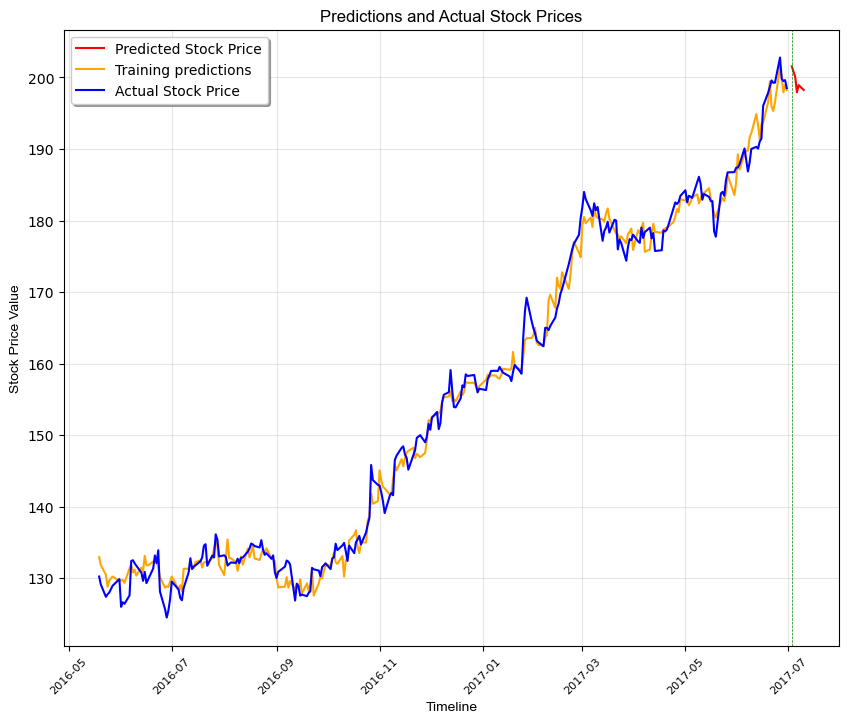

In [62]:
START_DATE_FOR_PLOTTING =  pd.to_datetime('2016-05-19')


STOP_DATE_FOR_PLOTTING = '2012-09-04'

plt.figure(figsize=(10,8))

plt.plot(XGB_PREDICTIONS_FUTURE.index, XGB_PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(XGB_PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, XGB_PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df1.loc[START_DATE_FOR_PLOTTING:].index, df1.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x=min(XGB_PREDICTIONS_FUTURE.index), color='green', linewidth=0.5, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.savefig('XGBpred.jpg', dpi=500,  bbox_inches='tight')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

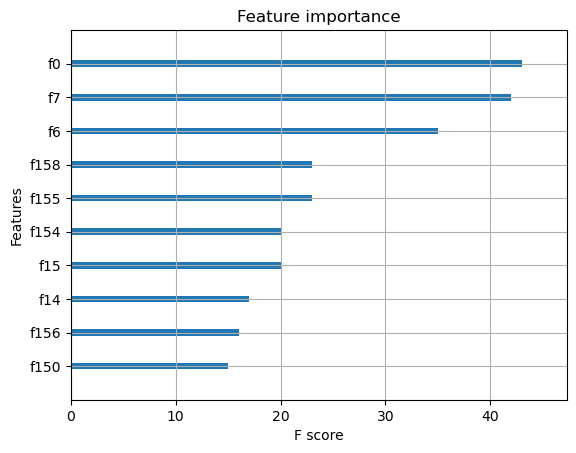

In [63]:
xgb.plot_importance(XGB, importance_type='weight', show_values=False, max_num_features=10)

This is to show that we also cannot have Feature Importance graph with all the relevant features as when the data is prepared for time seies, the lags are in separate columns indicating separate features here.

In [64]:
# XGB_Pred_copies = np.repeat(XGB_Pred, clean.shape[1], axis=-1)
# XGB_Pred = scaled.inverse_transform(XGB_Pred_copies)[:,0]

mae, mse, rmse  = evaluate(Y_test['Open'], XGB_Pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 10.825501274469493
Mean Squared Error: 3.0683470017578087
Root Mean Squared Error: 3.2902129527538935


## Random Forest

Just an extra step to double check the Stationarity.

In [65]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data_scaled[1])
print('p-value: %f' % result[1])

p-value: 0.000000


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [67]:
RFSearch = {
    'n_estimators':[10, 20, 50, 100],
    'max_depth': [None, 10, 50, 100],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2,5,10],
    'bootstrap': [True, False]
}



In [68]:
RF_X_train = X_train_LSTM.reshape(X_train_LSTM.shape[0],-1)
RF_X_test = X_test_LSTM.reshape(X_test_LSTM.shape[0],-1)

RF_Y_train = Y_train_LSTM
RF_Y_test = Y_test_LSTM

print(RF_X_train.shape)
print(RF_X_test.shape)
print(RF_Y_train.shape)
print(RF_Y_test.shape)

(1160, 160)
(20, 160)
(1160, 1)
(20, 1)


In [69]:
RF_model = RandomForestRegressor(random_state = 1)

In [374]:
grid_RF = GridSearchCV(RF_model, RFSearch, cv=3)
grid_RF.fit(RF_X_train, RF_Y_train)

#print(grid.best_params_)

best_para = grid_RF.best_params_

In [70]:
best_para = {'bootstrap': True,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50}

In [71]:
RF = RandomForestRegressor(random_state=1, **best_para)

RF.fit(RF_X_train, RF_Y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=50, random_state=1)

In [72]:
RF_Pred_scaled = RF.predict(RF_X_train[-nf:])

RF_Pred= RF_Pred_scaled.reshape(RF_Pred_scaled.shape[0],-1)

RF_Pred.shape

(5, 1)

In [73]:
RF_PastPred_scaled = RF.predict(RF_X_train[npast:])

RF_PastPred= RF_PastPred_scaled.reshape(RF_PastPred_scaled.shape[0],-1)

RF_PastPred.shape

(1140, 1)

In [74]:
RF_Pred_copies = np.repeat(RF_Pred, clean.shape[1], axis=-1)
RF_Pred = scaled.inverse_transform(RF_Pred_copies)[:,0]

RF_PastPred_copies = np.repeat(RF_PastPred, clean.shape[1], axis=-1)
RF_PastPred = scaled.inverse_transform(RF_PastPred_copies)[:,0]

In [75]:
RF_Pred

array([198.62756861, 198.62756861, 198.62756861, 198.62756861,
       198.44308371])

In [76]:
RF_PastPred

array([ 75.56835727,  75.56835727,  75.64534189, ..., 198.62756861,
       198.62756861, 198.44308371])

In [77]:
mae, mse, rmse = evaluate(Y_test['Open'], RF_Pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 7.5836021279106705
Mean Squared Error: 2.346357212911522
Root Mean Squared Error: 2.753834077774235


In [78]:
RF_PREDICTIONS_FUTURE = pd.DataFrame(RF_Pred, columns=['Open']).set_index(pd.Series(datelist_future[:nf])) # Changed datelist_future_ from datelist_future
RF_PREDICTION_TRAIN = pd.DataFrame(RF_PastPred, columns=['Open']).set_index(pd.Series(datelist_train[(2 * npast + nf -1): len(data_scaled_train)]))

#PREDICTION_TRAIN = pd.DataFrame(y_pred_past, columns=['Open']).set_index(pd.Series(datelist_train[:761]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
RF_PREDICTION_TRAIN.index = RF_PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

print(RF_PREDICTION_TRAIN.tail(30))
print(RF_PREDICTIONS_FUTURE.head(30))
print(RF_PREDICTION_TRAIN.shape)
print(RF_PREDICTION_TRAIN.index)
print(RF_PREDICTIONS_FUTURE.index)

                  Open
2017-05-19  180.654296
2017-05-22  181.250895
2017-05-23  182.290809
2017-05-24  181.725385
2017-05-25  182.372233
2017-05-26  183.681028
2017-05-30  184.320986
2017-05-31  184.151650
2017-06-01  184.674764
2017-06-02  186.342778
2017-06-05  188.047540
2017-06-06  187.311181
2017-06-07  187.493384
2017-06-08  188.309168
2017-06-09  190.408584
2017-06-12  191.402231
2017-06-13  191.307831
2017-06-14  190.045182
2017-06-15  191.916144
2017-06-16  196.810399
2017-06-19  196.697133
2017-06-20  197.014815
2017-06-21  197.590912
2017-06-22  197.388423
2017-06-23  198.017741
2017-06-26  198.627569
2017-06-27  198.627569
2017-06-28  198.627569
2017-06-29  198.627569
2017-06-30  198.443084
                  Open
2017-07-03  198.627569
2017-07-05  198.627569
2017-07-06  198.627569
2017-07-07  198.627569
2017-07-10  198.443084
(1140, 1)
DatetimeIndex(['2012-12-20', '2012-12-21', '2012-12-24', '2012-12-26',
               '2012-12-27', '2012-12-28', '2012-12-31', '2013-01-02

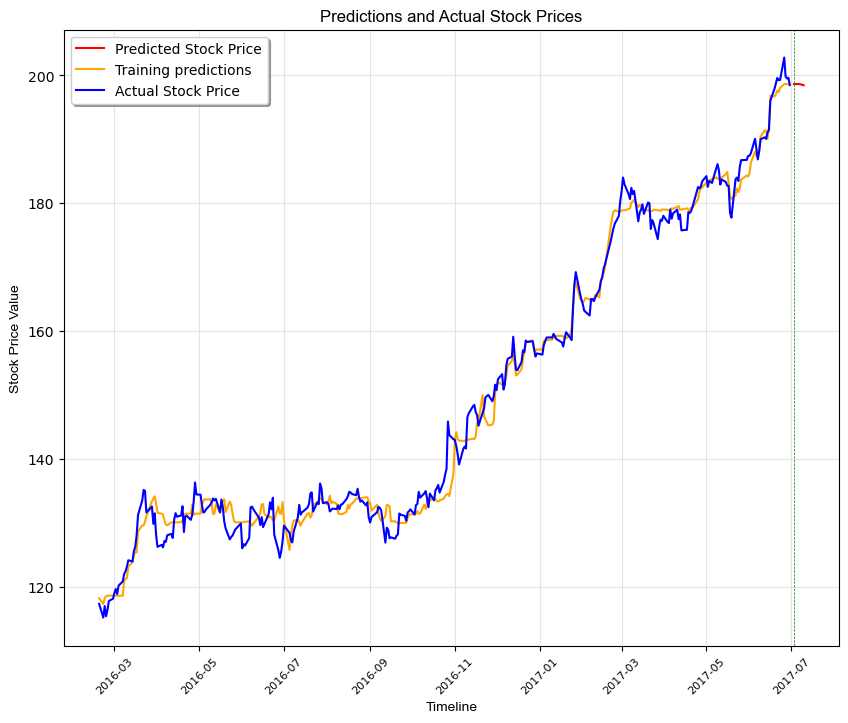

In [79]:
START_DATE_FOR_PLOTTING =  pd.to_datetime('2016-02-19')


STOP_DATE_FOR_PLOTTING = '2012-09-04'

plt.figure(figsize=(10,8))

plt.plot(RF_PREDICTIONS_FUTURE.index, RF_PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(RF_PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, RF_PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df1.loc[START_DATE_FOR_PLOTTING:].index, df1.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x=min(RF_PREDICTIONS_FUTURE.index), color='green', linewidth=0.5, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)

plt.savefig('RandomPred.jpg', dpi=500,  bbox_inches='tight')
plt.show()

In [6]:
#!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True --TemplateExporter.exclude_input_prompt=True Boeing_Stock_Prediction.ipynb